## Classifying Movie Reviews
*A binary classification example*
### Loading the Dataset
Load the dataset and keep the 10.000 most frequently occurring words.
The loaded data is split 50/50 into train data and test data.

In [11]:
laptop_flag = False

In [ ]:
# for running on CPU only (Laptop)
import os
# (opt.) force CPU use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
laptop_flag = True

In [12]:
from keras.datasets import imdb

# load data and split into training and test (50/50)
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## decode and display single entry of dataset
# get word -> index mapping from dataset
word_index = imdb.get_word_index()
# reverse to get index -> word mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# decode review
decoded_review = " ".join(reverse_word_index.get(i - 3, "?") for i in train_data[0])
#--- index offset because 0, 1, and 2 are reserved for "padding", "start of sequence" and "unknown"
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

### Prepare the Data
Only Tensors can be fed into a neural network, therefore two options:
1. pad lists to same length and turn into tensor of shape (samples, word_indices) e.g. for *Embedding Layer*
2. encode lists into vectors of size 10.000 e.g. for *Dense Layer*
    - index list of [3, 5] turns into vector with all 0 except for position 3 & 5

In [13]:
import numpy as np

# function to turn list of indices into vector with indices set to 1 (default 0)
def vectorize_sequences(sequences, dimension=10000):
    # create matrix of size: number of sequences (reviews) X dimension of sequence (10.000)
    results = np.zeros((len(sequences), dimension))
    # set indices of sequence to 1
    for i, seq in enumerate(sequences):
        results[i, seq] = 1
    return results

# vectorize training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# vectorize labels (already 1 = positive / 0 = negative)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building the Network
The network is proposed as:
+ 2 intermediate layers (Dense) with 16 hidden units & relu activations
+ 1 output layer (Dense) with 1 hidden unit & sigmoid activation

In [14]:
from keras import models, layers, optimizers, losses, metrics

# create sequential model to add layers
model = models.Sequential()
# add intermediate layers
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
# add output layer
model.add(layers.Dense(1, activation="sigmoid"))

# compiling model with rmsprop optimizer & binary_crossentropy loss function
model.compile(
    # configure optimizer
    optimizer=optimizers.RMSprop(lr=0.001),
    # configure loss function
    loss=losses.binary_crossentropy,
    # configure metrics
    metrics=[metrics.binary_accuracy]
)

### Validate & Train Model
Monitoring accuracy on never before seen images during training, by setting apart validation set from the training data (10.000 entries).
Added K-Fold Cross Validation, separating the training data into 5 partitions and training 5 networks each on 4 partitions with the 5th for validation.

| Fold |  Partition 1   |  Partition 2   |  Partition 3   |  Partition 4   |  Partition 5   |
|:----:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
|   1  | **Validation** |   *Training*   |   *Training*   |   *Training*   |   *Training*   |
|   2  |   *Training*   | **Validation** |   *Training*   |   *Training*   |   *Training*   |
|   3  |   *Training*   |   *Training*   | **Validation** |   *Training*   |   *Training*   |
|   4  |   *Training*   |   *Training*   |   *Training*   | **Validation** |   *Training*   |
|   5  |   *Training*   |   *Training*   |   *Training*   |   *Training*   | **Validation** |

The scores of the trained networks are averaged into a final evaluation score.

In [15]:
## Hold-out validation
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# create new model based on compiled layers
hold_model = models.clone_model(model)
hold_model.compile(
    optimizer=optimizers.RMSprop(lr=0.001),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

## train network
hold_history = hold_model.fit(
    partial_x_train,
    partial_y_train,
    # train samples for 20 iterations (epochs)
    epochs=5,
    # train in batches of 512
    batch_size=512,
    # provide validation data
    validation_data=(x_val, y_val)
)
results = model.evaluate(x_test, y_test)
print(results)

Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 3s 229us/step - loss: 0.5344 - binary_accuracy: 0.7746 - val_loss: 0.3943 - val_binary_accuracy: 0.8687
Epoch 2/5
15000/15000 [==============================] - 2s 164us/step - loss: 0.3181 - binary_accuracy: 0.8973 - val_loss: 0.3277 - val_binary_accuracy: 0.8713
Epoch 3/5
15000/15000 [==============================] - 2s 159us/step - loss: 0.2343 - binary_accuracy: 0.9245 - val_loss: 0.2862 - val_binary_accuracy: 0.8881
Epoch 4/5
15000/15000 [==============================] - 2s 161us/step - loss: 0.1844 - binary_accuracy: 0.9400 - val_loss: 0.2745 - val_binary_accuracy: 0.8905
Epoch 5/5
25000/25000 [==============================] - 4s 161us/step
[0.6944457488250733, 0.49572]


In [16]:
## K-fold validation
k = 5
num_val_samples = len(x_train) // k
# shuffle data
idx = np.random.permutation(len(x_train))
x_train_shuffled, y_train_shuffled = x_train[idx], y_train[idx]

histories = {}
fold_models = {}
validation_scores = []
for fold in range(k):
    # segment validation data
    x_val = x_train_shuffled[num_val_samples * fold : num_val_samples * (fold+1)]
    y_val = y_train_shuffled[num_val_samples * fold : num_val_samples * (fold+1)]
    # segment remaining training data
    x_trn = np.concatenate((x_train_shuffled[:num_val_samples * fold], x_train_shuffled[num_val_samples * (fold+1):]))
    y_trn = np.concatenate((y_train_shuffled[:num_val_samples * fold], y_train_shuffled[num_val_samples * (fold+1):]))
    
    # create new model based on compiled layers
    fold_model = models.clone_model(model)
    fold_model.compile(
        optimizer=optimizers.RMSprop(lr=0.001),
        loss=losses.binary_crossentropy,
        metrics=[metrics.binary_accuracy]
    )
    print("----- Training Fold {} -----".format(fold+1))
    # train each model
    fold_history = fold_model.fit(
        x_trn,
        y_trn,
        epochs=5,
        batch_size=512,
        validation_data=(x_val, y_val)
    )
    # append training history and model into dicts
    histories.update({fold: fold_history.history})
    fold_models.update({fold: fold_model})
    # evaluate model on test data and save to list 
    result = fold_model.evaluate(x_test, y_test)
    validation_scores.append(result)
# calculate average of evaluation scores
validation_score = np.mean(validation_scores, axis=0)
print(validation_scores)
print(validation_score)

----- Training Fold 1 -----
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 3s 171us/step - loss: 0.4608 - binary_accuracy: 0.8094 - val_loss: 0.3342 - val_binary_accuracy: 0.8852
Epoch 2/5
20000/20000 [==============================] - 2s 125us/step - loss: 0.2693 - binary_accuracy: 0.9085 - val_loss: 0.2787 - val_binary_accuracy: 0.8934
Epoch 3/5
20000/20000 [==============================] - 2s 125us/step - loss: 0.2049 - binary_accuracy: 0.9285 - val_loss: 0.2886 - val_binary_accuracy: 0.8868
Epoch 4/5
20000/20000 [==============================] - 2s 124us/step - loss: 0.1698 - binary_accuracy: 0.9415 - val_loss: 0.2816 - val_binary_accuracy: 0.8884
Epoch 5/5
25000/25000 [==============================] - 4s 146us/step
----- Training Fold 2 -----
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 3s 158us/step - loss: 0.4826 - binary_accuracy: 0.8056 - val_loss: 0.3876 

### visualize training history
Plotting training and validation loss.

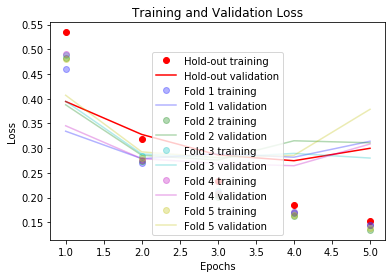

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(histories[0]["loss"])+1)

## plot hold-out history
hold_loss_values = hold_history.history["loss"]
hold_val_loss_values = hold_history.history["val_loss"]
# plot training loss in red, dotted
plt.plot(epochs, hold_loss_values, "ro", label="Hold-out training")
# plot validation loss in red, solid
plt.plot(epochs, hold_val_loss_values, "r", label="Hold-out validation")

## plot fold histories
for idx, history_dict in histories.items():
    fold_loss_values = history_dict["loss"]
    fold_val_loss_values = history_dict["val_loss"]
    color = ["b", "g", "c", "m", "y"][idx]
    # plot training loss dotted
    plt.plot(epochs, fold_loss_values, "{}o".format(color), label="Fold {} training".format(idx+1), alpha=0.3)
    # plot validation loss solid
    plt.plot(epochs, fold_val_loss_values, "{}".format(color), label="Fold {} validation".format(idx+1), alpha=0.3)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

Plotting training and validation accuracy.

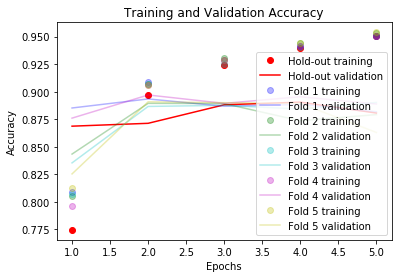

In [18]:
plt.clf()
## plot hold-out history
hold_acc_values = hold_history.history["binary_accuracy"]
hold_val_acc_values = hold_history.history["val_binary_accuracy"]
# plot training loss in red, dotted
plt.plot(epochs, hold_acc_values, "ro", label="Hold-out training")
# plot validation loss in red, solid
plt.plot(epochs, hold_val_acc_values, "r", label="Hold-out validation")

## plot fold histories
for idx, history_dict in histories.items():
    fold_acc_values = history_dict["binary_accuracy"]
    fold_val_acc_values = history_dict["val_binary_accuracy"]
    color = ["b", "g", "c", "m", "y"][idx]
    # plot training loss in blue, dotted
    plt.plot(epochs, fold_acc_values, "{}o".format(color), label="Fold {} training".format(idx+1), alpha=0.3)
    # plot validation loss in blue, solid
    plt.plot(epochs, fold_val_acc_values, "{}".format(color), label="Fold {} validation".format(idx+1), alpha=0.3)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Prediction of New Data

In [28]:
hold_predictions = hold_model.predict(x_test)
fold_predictions = [None]*k
for idx, model in fold_models.items():
    fold_predictions[idx] = model.predict(x_test)

# print sample with prediction result
review_idx = np.random.randint(0, 25000-1)
review_text = " ".join(reverse_word_index.get(i - 3, "?") for i in test_data[review_idx])
print(review_text)
review_hold_pred = hold_predictions[review_idx]
review_fold_predictions = []
for preds in fold_predictions:
    review_fold_predictions.append(np.asscalar(preds[review_idx]))
review_fold_pred = np.mean(review_fold_predictions, axis=0)

print("Review predictions:")
print("Hold-out Model:    {}".format(review_fold_pred))
print("Fold Model (avg.): {}; {}".format(review_fold_pred, review_fold_predictions))


? hated it with all my being worst movie ever mentally ? help me it was that bad trust me
Review predictions:
Hold-out Model:    0.1826632499694824
Fold Model (avg.): 0.1826632499694824; [0.1818338930606842, 0.1620619297027588, 0.17216190695762634, 0.2130042314529419, 0.18425428867340088]
